# Nerdle Solver - Initial Guess Assessment Optimization
We prove (by brute-force) that you can always solve mini-Nerdle in at most $4$ guesses regardless of the starting expression, provided you use the optimal strategy. The worst start having repeating numbers and thus less information, e.g. `10-5=5`. The best start has all different numbers: `28/7=4`, which needs at most $3$ guesses and $2.65 \pm 0.5$ guesses.

To find the best initial guess, we map out the game tree.

In [300]:
%load_ext autoreload
%autoreload 2

import collections
import ctypes
import itertools
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt

import analysis
import nerdle
import score as s
import generator
sgo = ctypes.CDLL(s.SCORE_GUESS_OPT_SO)
from nerdle import Hint

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [301]:
# Mini-Nerdle.
NUM_SLOTS = 6
SCORE_DB_FILE = "db/nerdle{}.db".format(NUM_SLOTS) 
solver_data = nerdle.create_solver_data(NUM_SLOTS, SCORE_DB_FILE)
d = solver_data.score_db
print(d.shape)

(206, 206)


## Initial Guess Optimization

In [302]:
# # For each initial guess, calculate the distribution of #guesses required to get the answer, over all answers.
# # This takes ~1.3s / initial guess = 4.5 min total.
# num_guesses = np.array([
#     [len(nerdle.NerdleSolver(solver_data).solve(answer, initial_guess=start)[1]) for answer in solver_data.answers]
#     for start in solver_data.answers
# ])

In [303]:
# fig, axs = plt.subplots(1, 3, figsize=(10, 4))

# ax = axs[0]
# ax.hist(np.max(num_guesses, axis=1))
# ax.set_title("Max # Guesses")

# ax = axs[1]
# ax.hist(np.mean(num_guesses, axis=1), 30)
# ax.set_title("Mean # Guesses")

# ax = axs[2]
# ax.hist(np.std(num_guesses, axis=1), 30)
# ax.set_title("Stddev of # Guesses");

In [304]:
# # Best starts.
# worst_num_guesses = np.max(num_guesses, axis=1)
# print("Min (max # guesses)", min(worst_num_guesses))
# idx = np.where(worst_num_guesses == min(worst_num_guesses))[0]
# print(idx)
# best_starts = np.array(solver_data.answers)[idx]

# print("Best starts", best_starts)
# mean_best = np.mean(num_guesses[idx], axis=1)
# mean_best_argmin = np.argmin(mean_best)
# print("Best mean # guesses among those {} mean # guesses {:.2f} +- {:.2f} idx {}".format(
#     solver_data.answers[idx[mean_best_argmin]], mean_best[mean_best_argmin], np.std(num_guesses[idx[mean_best_argmin]]),
#     idx[mean_best_argmin]))

# # Worst starts.
# print("Max (max # guesses)", max(worst_num_guesses))
# idx = np.where(worst_num_guesses == max(worst_num_guesses))[0]
# print(idx)
# worst_starts = np.array(solver_data.answers)[idx]

# print("Worst starts", worst_starts)

In [305]:
# # Every initial guess' distribution of #guesses has to have a single "1" value.
# start = best_starts[0]
# solutions = [nerdle.NerdleSolver(solver_data).solve(answer, initial_guess=str(start)) 
#              for answer in solver_data.answers ]               
# n = np.array([len(solution[0]) for solution in solutions])
# num_answers = len(solver_data.answers)
# compression_ratio = num_answers / np.array([solution[2][0] for solution in solutions])
# print(np.mean(compression_ratio), np.std(compression_ratio))

# fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# ax = axs[0]
# ax.hist(n);
# ax.set_title("#Guesses for start {}".format(start));

# ax = axs[1]
# ax.hist(compression_ratio);
# ax.set_title("Compression Ratio Distribution, start {}".format(start));

 Node[key=87, answers=206, score=(206, 206), children=73]
	 Node[key=145, answers=9, score=(206, 9), children=9]
		 Node[key=None, answers=1, score=(206, 1), children=0]
		 Node[key=None, answers=1, score=(206, 1), children=0]
		 Node[key=None, answers=1, score=(206, 1), children=0]
		 Node[key=None, answers=1, score=(206, 1), children=0]
		 Node[key=None, answers=1, score=(206, 1), children=0]
		 Node[key=None, answers=1, score=(206, 1), children=0]
		 Node[key=None, answers=1, score=(206, 1), children=0]
		 Node[key=None, answers=1, score=(206, 1), children=0]
		 Node[key=None, answers=1, score=(206, 1), children=0]
	 Node[key=44, answers=9, score=(206, 9), children=9]
		 Node[key=None, answers=1, score=(206, 1), children=0]
		 Node[key=None, answers=1, score=(206, 1), children=0]
		 Node[key=None, answers=1, score=(206, 1), children=0]
		 Node[key=None, answers=1, score=(206, 1), children=0]
		 Node[key=None, answers=1, score=(206, 1), children=0]
		 Node[key=None, answers=1, score=

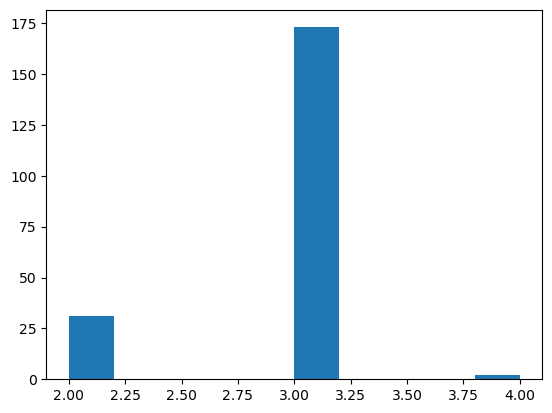

In [312]:
tree = analysis.GameTreeBuilder(solver_data).build(debug=True)
tdc = TreeDepthCalculator(tree)

# Distribution of #guesses for all answers.
num_guesses = np.array([depth for node, depth in tdc.depth.items() if not node.children]) + 1
freq = collections.Counter(num_guesses)
num_nodes = sum(1 for node in tdc.depth if not node.children)
assert num_nodes == len(answers)
for k, v in sorted(freq.items()):
    print("{} guesses: {:6.2f}%".format(k, 100 * v / num_nodes))
plt.hist(num_guesses);